# SWE-bench Model Performance Analysis

## Overview
Comprehensive analysis of 34 bash-only SWE-bench models from the last 6 months.

**Key Features:**
- Fetch instance-level results from GitHub for all 34 models
- Differential analysis: which instances are solved by some models but not others
- Per-cluster performance comparison
- Interactive visualizations

## Google Colab Setup
1. Run the install cell below
2. Upload required JSON files when prompted:
   - `verified_cluster_assignments.json`
   - `selected_cluster_centroids.json`
3. Enter your GitHub token when prompted (for API access)

In [1]:
# ============================================================
# STEP 1: Install required libraries
# ============================================================
!pip install -q PyGithub pandas numpy plotly matplotlib seaborn scipy

print("✅ Dependencies installed!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.7/432.7 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 61.7 MB/s eta 0:00:00
✅ Dependencies installed!


In [2]:
# ============================================================
# STEP 2: Upload required JSON files
# ============================================================
# You need to upload these files from clustering_21122025/:
#   - verified_cluster_assignments.json
#   - selected_cluster_centroids.json

from google.colab import files
import os

# Create directories
os.makedirs("/content/data", exist_ok=True)
os.makedirs("/content/cache", exist_ok=True)

print("📁 Please upload the following files:")
print("   1. verified_cluster_assignments.json")
print("   2. selected_cluster_centroids.json")
print("")

uploaded = files.upload()

# Move uploaded files to data directory
for filename in uploaded.keys():
    os.rename(filename, f"/content/data/{filename}")
    print(f"✅ Uploaded: {filename}")

print("\n✅ Files uploaded successfully!")

📁 Please upload the following files:
   1. verified_cluster_assignments.json
   2. selected_cluster_centroids.json



Saving verified_cluster_assignments.json to verified_cluster_assignments.json
✅ Uploaded: verified_cluster_assignments.json

✅ Files uploaded successfully!


In [ ]:
# ============================================================
# STEP 3: Set up GitHub Token
# ============================================================
# You need a GitHub token for API access (higher rate limits)
# Get one at: https://github.com/settings/tokens

import os
import getpass

# Option 1: Use Colab Secrets (recommended)
try:
    from google.colab import userdata
    GITHUB_TOKEN = userdata.get("GITHUB_TOKEN")
    if GITHUB_TOKEN:
        print("✅ Using GitHub token from Colab Secrets")
    else:
        raise ValueError("Token not found in secrets")
except:
    # Option 2: Environment variable
    GITHUB_TOKEN = os.environ.get("GITHUB_TOKEN")
    if GITHUB_TOKEN:
        print("✅ Using GitHub token from environment variable")
    else:
        # Option 3: Manual input
        print("Enter your GitHub token (or press Enter to skip):")
        GITHUB_TOKEN = getpass.getpass("GitHub Token: ")
        if GITHUB_TOKEN:
            print("✅ GitHub token set")
        else:
            print("⚠️ No token - using unauthenticated access (lower rate limits)")
            GITHUB_TOKEN = None

---
## Section 1: Setup & Data Loading

In [4]:
# Core imports
import json
import os
import base64
import warnings
from pathlib import Path
from collections import Counter
from datetime import datetime

# Data processing
import numpy as np
import pandas as pd

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

# GitHub API
from github import Auth, Github

# Clustering metrics
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

# Settings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Colab paths
DATA_DIR = Path("/content/data")
CACHE_DIR = Path("/content/cache")
CACHE_DIR.mkdir(exist_ok=True)

print("✅ Imports loaded successfully!")

✅ Imports loaded successfully!


In [6]:
# Initialize GitHub client
def get_github_client():
    """Create GitHub client with token for higher rate limits."""
    if GITHUB_TOKEN and GITHUB_TOKEN.strip():
        print("Using GitHub token for authentication")
        auth = Auth.Token(GITHUB_TOKEN.strip())
        return Github(auth=auth)
    print("⚠️ No GitHub token, using unauthenticated access (lower rate limits)")
    return Github()

gh = get_github_client()

# Check rate limit
rate_limit = gh.get_rate_limit()


Using GitHub token for authentication


In [7]:
# Load verified cluster assignments
verified_path = DATA_DIR / "verified_cluster_assignments.json"
with open(verified_path) as f:
    verified_data = json.load(f)

instance_ids = verified_data["instance_ids"]
cluster_labels = verified_data["cluster_labels"]

print(f"✅ Loaded {len(instance_ids)} verified instances")
print(f"Clusters: {sorted(set(cluster_labels))}")

# Create mapping
instance_to_cluster = dict(zip(instance_ids, cluster_labels))

# Load cluster centroids for metadata
centroids_path = DATA_DIR / "selected_cluster_centroids.json"
with open(centroids_path) as f:
    centroids_data = json.load(f)

n_clusters = centroids_data["metrics"]["n_clusters"]
print(f"\nNumber of clusters: {n_clusters}")
print(f"Silhouette score: {centroids_data['metrics']['silhouette']:.4f}")

✅ Loaded 500 verified instances
Clusters: [0, 1, 2, 3, 4, 5, 6]

Number of clusters: 7
Silhouette score: 0.5236


In [8]:
# Define all 34 bash-only models to analyze
ALL_MODELS = [
    # July 2025
    "20250720_mini-v0.0.0-Llama-4-Maverick-17B-Instruct",
    "20250720_mini-v0.0.0-Llama-4-Scout-17B-Instruct",
    "20250720_mini-v0.0.0-claude-3-7-sonnet-20250219",
    "20250720_mini-v0.0.0-gpt-4o-2024-11-20",
    "20250720_mini-v0.0.0_gpt-4.1-mini-2025-04-14",
    "20250726_mini-v1.0.0_claude-sonnet-4-20250514",
    "20250726_mini-v1.0.0_gemini-2.0-flash",
    "20250726_mini-v1.0.0_gemini-2.5-flash",
    "20250726_mini-v1.0.0_gemini-2.5-pro",
    "20250726_mini-v1.0.0_gpt-4.1-2025-04-14",
    "20250726_mini-v1.0.0_o3-2025-04-16",
    "20250726_mini-v1.0.0_o4-mini-2025-04-16",
    # August 2025
    "20250802_mini-v1.0.0_claude-4-opus-20250514",
    "20250802_mini-v1.0.0_qwen3-coder-480b-a35b-instruct",
    "20250803_mini-v1.0.0_qwen2-5-coder-32b-instruct",
    "20250807_mini-v1.7.0_gpt-5",
    "20250807_mini-v1.7.0_gpt-5-mini",
    "20250807_mini-v1.7.0_gpt-5-nano",
    "20250807_mini-v1.7.0_gpt-oss-120b",
    "20250807_mini-v1.7.0_kimi-k2-instruct",
    "20250822_mini-v1.9.1_glm-4.5",
    # September 2025
    "20250929_mini-v1.13.3_sonnet-4-5-20250929",
    # November 2025
    "20251118_mini-v1.15.0_gemini-3-pro-preview-20251118",
    "20251120_mini-v1.15.0_gpt-5.1-2025-11-13",
    "20251124_mini-v1.16.0_claude-opus-4-5-20251101",
    "20251124_mini-v1.16.0_gpt-5.1-codex",
    "20251124_mini-v1.17.0_minimax-m2",
    # December 2025
    "20251201_mini-v1.17.1_deepseek-v3.2-reasoner",
    "20251201_mini-v1.17.1_glm-4.6",
    "20251209_mini-v1.17.2_devstral-2512",
    "20251209_mini-v1.17.2_devstral-small-2512",
    "20251210_mini-v1.17.2_kimi-k2-thinking",
    "20251211_mini-v1.17.2_gpt-5.2-2025-12-11",
    "20251211_mini-v1.17.2_gpt-5.2-2025-12-11-high",
]

print(f"Total models to analyze: {len(ALL_MODELS)}")

# Helper function to extract model info
def parse_model_info(model_folder):
    """Extract date, model name, and provider from folder name."""
    parts = model_folder.split("_")
    date_str = parts[0]  # e.g., "20250720"
    model_name = "_".join(parts[2:]) if len(parts) > 2 else parts[-1]

    # Detect provider
    model_lower = model_name.lower()
    if "claude" in model_lower or "sonnet" in model_lower or "opus" in model_lower:
        provider = "Anthropic"
    elif "gpt" in model_lower or "o3" in model_lower or "o4" in model_lower:
        provider = "OpenAI"
    elif "gemini" in model_lower:
        provider = "Google"
    elif "llama" in model_lower or "maverick" in model_lower or "scout" in model_lower:
        provider = "Meta"
    elif "qwen" in model_lower:
        provider = "Alibaba"
    elif "deepseek" in model_lower:
        provider = "DeepSeek"
    elif "glm" in model_lower:
        provider = "Zhipu"
    elif "kimi" in model_lower:
        provider = "Moonshot"
    elif "devstral" in model_lower:
        provider = "Mistral"
    elif "minimax" in model_lower:
        provider = "MiniMax"
    else:
        provider = "Unknown"

    return {
        "date": date_str,
        "model_name": model_name,
        "provider": provider
    }

# Test parsing
for m in ALL_MODELS[:3]:
    info = parse_model_info(m)
    print(f"{m[:40]}... -> {info['provider']}: {info['model_name']}")

Total models to analyze: 34
20250720_mini-v0.0.0-Llama-4-Maverick-17... -> Meta: mini-v0.0.0-Llama-4-Maverick-17B-Instruct
20250720_mini-v0.0.0-Llama-4-Scout-17B-I... -> Meta: mini-v0.0.0-Llama-4-Scout-17B-Instruct
20250720_mini-v0.0.0-claude-3-7-sonnet-2... -> Anthropic: mini-v0.0.0-claude-3-7-sonnet-20250219


---
## Section 2: Fetch Instance-Level Results from GitHub

In [9]:
REPO_NAME = "swe-bench/experiments"
EVAL_TYPE = "bash-only"
RESULTS_FILE = "per_instance_details.json"

def fetch_model_results(gh, model_folder, cache_dir=CACHE_DIR):
    """Fetch resolved instance IDs for a model from GitHub.

    Uses local cache to avoid repeated API calls.
    """
    cache_file = cache_dir / f"{model_folder}_results.json"

    # Check cache first
    if cache_file.exists():
        with open(cache_file) as f:
            cached = json.load(f)
        return set(cached["resolved"])

    # Fetch from GitHub
    try:
        repo = gh.get_repo(REPO_NAME)
        file_path = f"evaluation/{EVAL_TYPE}/{model_folder}/{RESULTS_FILE}"

        content = repo.get_contents(file_path)
        if isinstance(content, list):
            content = content[0]

        decoded = base64.b64decode(content.content).decode("utf-8")
        data = json.loads(decoded)

        # Parse bash-only format: {"id": {"resolved": true/false, ...}}
        resolved = {id for id, info in data.items() if info.get("resolved", False)}

        # Cache results
        with open(cache_file, "w") as f:
            json.dump({"resolved": list(resolved)}, f)

        return resolved

    except Exception as e:
        print(f"  ❌ Error: {e}")
        return set()

print("✅ Fetch function defined!")

✅ Fetch function defined!


In [12]:
# Fetch results for all models
print("Fetching results for all models...")
print("(Using cache when available)\n")

model_results_temp = {}  # Temporary storage for results
successful_models = [] # List to store models that successfully fetched results
total_models = len(ALL_MODELS) # Keep original count for printing

for i, model in enumerate(ALL_MODELS, 1):
    print(f"[{i:2d}/{total_models}] {model[:50]}...", end=" ")

    resolved = fetch_model_results(gh, model)

    # Only include models that resolved at least one instance or successfully fetched data
    if len(resolved) > 0:
        model_results_temp[model] = resolved
        successful_models.append(model)
        # Filter to verified instances only
        verified_resolved = resolved & set(instance_ids)
        print(f"Resolved: {len(verified_resolved)}/500 verified")
    else:
        print("Skipped (no resolved instances or 404 error)")


# Update global variables with filtered data
ALL_MODELS = successful_models
model_results = model_results_temp

print(f"\n✅ Done! Loaded results for {len(ALL_MODELS)} models (filtered out those with 404 or no resolved instances).")

Fetching results for all models...
(Using cache when available)

[ 1/34] 20250720_mini-v0.0.0-Llama-4-Maverick-17B-Instruct... Resolved: 105/500 verified
[ 2/34] 20250720_mini-v0.0.0-Llama-4-Scout-17B-Instruct...   ❌ Error: 404 {"message": "Not Found", "documentation_url": "https://docs.github.com/rest/repos/contents#get-repository-content", "status": "404"}
Skipped (no resolved instances or 404 error)
[ 3/34] 20250720_mini-v0.0.0-claude-3-7-sonnet-20250219... Resolved: 51/500 verified
[ 4/34] 20250720_mini-v0.0.0-gpt-4o-2024-11-20...   ❌ Error: 404 {"message": "Not Found", "documentation_url": "https://docs.github.com/rest/repos/contents#get-repository-content", "status": "404"}
Skipped (no resolved instances or 404 error)
[ 5/34] 20250720_mini-v0.0.0_gpt-4.1-mini-2025-04-14...   ❌ Error: 404 {"message": "Not Found", "documentation_url": "https://docs.github.com/rest/repos/contents#get-repository-content", "status": "404"}
Skipped (no resolved instances or 404 error)
[ 6/34] 20250726_

In [13]:
# Create instance x model matrix (500 x 34)
print("Creating instance x model matrix...")

# Build matrix: rows = instances, columns = models
matrix_data = []

for instance_id in instance_ids:
    row = {"instance_id": instance_id}
    for model in ALL_MODELS:
        # Short model name for column
        short_name = parse_model_info(model)["model_name"]
        row[short_name] = 1 if instance_id in model_results[model] else 0
    matrix_data.append(row)

df_matrix = pd.DataFrame(matrix_data)
df_matrix.set_index("instance_id", inplace=True)

print(f"Matrix shape: {df_matrix.shape}")
print(f"\nInstances x Models: {len(instance_ids)} x {len(ALL_MODELS)}")

# Add metadata columns
df_matrix["cluster"] = df_matrix.index.map(instance_to_cluster)
df_matrix["n_models_solved"] = df_matrix.iloc[:, :-1].sum(axis=1)
df_matrix["repo"] = df_matrix.index.str.split("__").str[0]

print(f"\nSolve distribution:")
print(df_matrix["n_models_solved"].describe())

Creating instance x model matrix...
Matrix shape: (500, 28)

Instances x Models: 500 x 28

Solve distribution:
count    500.000000
mean      15.106000
std        9.174044
min        0.000000
25%        6.000000
50%       19.000000
75%       23.000000
max       28.000000
Name: n_models_solved, dtype: float64


---
## Section 3: Model Performance Overview

In [14]:
# Calculate performance summary for each model
model_summary = []

for model in ALL_MODELS:
    info = parse_model_info(model)
    resolved = model_results[model]
    verified_resolved = resolved & set(instance_ids)

    model_summary.append({
        "model_folder": model,
        "model_name": info["model_name"],
        "provider": info["provider"],
        "date": info["date"],
        "resolved_count": len(verified_resolved),
        "resolve_rate": len(verified_resolved) / 500,
        "month": info["date"][:6]  # YYYYMM
    })

df_summary = pd.DataFrame(model_summary)
df_summary = df_summary.sort_values("resolved_count", ascending=False).reset_index(drop=True)

print("Model Performance Summary (sorted by resolved count):")
print("=" * 80)
display(df_summary[["model_name", "provider", "resolved_count", "resolve_rate"]].head(20))

Model Performance Summary (sorted by resolved count):


,model_name,provider,resolved_count,resolve_rate
0,claude-opus-4-5-20251101,Anthropic,372,0.744
1,gemini-3-pro-preview-20251118,Google,371,0.742
2,gpt-5.2-2025-12-11-high,OpenAI,359,0.718
3,sonnet-4-5-20250929,Anthropic,353,0.706
4,gpt-5.2-2025-12-11,OpenAI,345,0.690
5,claude-4-opus-20250514,Anthropic,338,0.676
6,gpt-5.1-2025-11-13,OpenAI,330,0.660
7,gpt-5.1-codex,OpenAI,330,0.660
8,gpt-5,OpenAI,325,0.650
9,claude-sonnet-4-20250514,Anthropic,324,0.648


In [15]:
# Horizontal bar chart of all models
fig = px.bar(
    df_summary.sort_values("resolved_count"),
    x="resolved_count",
    y="model_name",
    color="provider",
    orientation="h",
    title="SWE-bench Verified: Resolved Instances by Model (34 models)",
    labels={"resolved_count": "Resolved Instances (out of 500)", "model_name": "Model"},
    height=900,
    color_discrete_sequence=px.colors.qualitative.Set2
)

fig.update_layout(
    yaxis={"categoryorder": "total ascending"},
    showlegend=True,
    legend_title="Provider"
)

fig.show()

In [16]:
# Provider summary
provider_stats = df_summary.groupby("provider").agg({
    "resolved_count": ["mean", "max", "min", "count"]
}).round(1)
provider_stats.columns = ["Avg Resolved", "Best", "Worst", "Num Models"]
provider_stats = provider_stats.sort_values("Avg Resolved", ascending=False)

print("\nPerformance by Provider:")
print("=" * 60)
display(provider_stats)


Performance by Provider:


,Avg Resolved,Best,Worst,Num Models
provider,,,,
Google,319.5,371,268,2
MiniMax,305.0,305,305,1
DeepSeek,300.0,300,300,1
Anthropic,287.6,372,51,5
OpenAI,280.9,359,130,10
Mistral,275.5,282,269,2
Zhipu,274.0,277,271,2
Moonshot,268.0,317,219,2
Alibaba,161.0,277,45,2


---
## Section 4: Per-Cluster Analysis

In [17]:
# Calculate per-cluster error rates for each model
cluster_stats = {}

for model in ALL_MODELS:
    info = parse_model_info(model)
    model_name = info["model_name"]
    resolved = model_results[model]

    cluster_stats[model_name] = {}

    for cluster_id in range(n_clusters):
        cluster_instances = [iid for iid in instance_ids if instance_to_cluster[iid] == cluster_id]
        cluster_resolved = sum(1 for iid in cluster_instances if iid in resolved)

        total = len(cluster_instances)
        error_rate = 1 - (cluster_resolved / total) if total > 0 else 1.0

        cluster_stats[model_name][cluster_id] = {
            "total": total,
            "resolved": cluster_resolved,
            "error_rate": error_rate
        }

# Create error rate matrix for heatmap
error_matrix = pd.DataFrame({
    model: [cluster_stats[model][c]["error_rate"] for c in range(n_clusters)]
    for model in cluster_stats
}, index=[f"Cluster {c}" for c in range(n_clusters)])

print(f"Error rate matrix shape: {error_matrix.shape}")
print(f"Clusters: {n_clusters}, Models: {len(error_matrix.columns)}")

Error rate matrix shape: (7, 28)
Clusters: 7, Models: 28


In [18]:
# Cluster x Model heatmap (7 x 34)
fig = px.imshow(
    error_matrix.T,
    labels=dict(x="Cluster", y="Model", color="Error Rate"),
    title="Error Rate per Model per Cluster (lower is better)",
    aspect="auto",
    color_continuous_scale="RdYlGn_r",  # Red = high error, Green = low
    height=900
)

fig.update_layout(
    xaxis_title="Cluster",
    yaxis_title="Model"
)

fig.show()

In [19]:
# Best model per cluster
print("Best Model per Cluster:")
print("=" * 60)

for cluster_id in range(n_clusters):
    cluster_col = f"Cluster {cluster_id}"
    best_model = error_matrix.loc[cluster_col].idxmin()
    best_error = error_matrix.loc[cluster_col].min()

    cluster_size = sum(1 for c in cluster_labels if c == cluster_id)
    print(f"  {cluster_col} ({cluster_size} instances): {best_model} (error: {best_error:.2%})")

Best Model per Cluster:
  Cluster 0 (125 instances): claude-opus-4-5-20251101 (error: 26.40%)
  Cluster 1 (46 instances): gpt-5.2-2025-12-11-high (error: 32.61%)
  Cluster 2 (137 instances): claude-opus-4-5-20251101 (error: 21.90%)
  Cluster 3 (38 instances): sonnet-4-5-20250929 (error: 18.42%)
  Cluster 4 (49 instances): gemini-3-pro-preview-20251118 (error: 24.49%)
  Cluster 5 (10 instances): gemini-3-pro-preview-20251118 (error: 0.00%)
  Cluster 6 (95 instances): claude-opus-4-5-20251101 (error: 22.11%)


---
## Section 5: Differential Analysis

**Key Question**: Which instances are solved by some models but not others?

In [20]:
# Categorize instances by solve difficulty
model_cols = [parse_model_info(m)["model_name"] for m in ALL_MODELS]
n_solved = df_matrix[model_cols].sum(axis=1)

universal_success = n_solved[n_solved == 34].index.tolist()  # All 34 models solved
universal_failure = n_solved[n_solved == 0].index.tolist()   # No model solved
unique_solves = n_solved[n_solved == 1].index.tolist()       # Only 1 model solved
controversial = n_solved[(n_solved >= 5) & (n_solved <= 29)].index.tolist()  # Mixed

print("Instance Categories:")
print("=" * 60)
print(f"  Universal Success (all 34 solved): {len(universal_success)}")
print(f"  Universal Failure (none solved):   {len(universal_failure)}")
print(f"  Unique Solves (only 1 model):      {len(unique_solves)}")
print(f"  Controversial (5-29 models):       {len(controversial)}")
print(f"  Total:                             {len(instance_ids)}")

Instance Categories:
  Universal Success (all 34 solved): 0
  Universal Failure (none solved):   63
  Unique Solves (only 1 model):      17
  Controversial (5-29 models):       390
  Total:                             500


In [21]:
# Distribution of solve difficulty
difficulty_counts = n_solved.value_counts().sort_index()

fig = px.bar(
    x=difficulty_counts.index,
    y=difficulty_counts.values,
    title="Instance Difficulty Distribution: How Many Models Solved Each Instance?",
    labels={"x": "Number of Models that Solved", "y": "Number of Instances"},
    color=difficulty_counts.index,
    color_continuous_scale="RdYlGn"
)

fig.update_layout(
    xaxis=dict(dtick=1),
    showlegend=False
)

fig.show()

In [22]:
# Analyze unique solves - which model solved what no one else could?
print("Unique Solves - Instances solved by only ONE model:")
print("=" * 80)

unique_solve_by_model = {}

for instance_id in unique_solves:
    row = df_matrix.loc[instance_id, model_cols]
    solving_model = row[row == 1].index[0]

    if solving_model not in unique_solve_by_model:
        unique_solve_by_model[solving_model] = []
    unique_solve_by_model[solving_model].append(instance_id)

# Sort by number of unique solves
sorted_unique = sorted(unique_solve_by_model.items(), key=lambda x: len(x[1]), reverse=True)

for model, instances in sorted_unique[:15]:
    print(f"  {model}: {len(instances)} unique solves")
    for inst in instances[:3]:
        print(f"    - {inst}")
    if len(instances) > 3:
        print(f"    ... and {len(instances) - 3} more")

Unique Solves - Instances solved by only ONE model:
  claude-opus-4-5-20251101: 6 unique solves
    - django__django-12406
    - django__django-15957
    - matplotlib__matplotlib-21568
    ... and 3 more
  gemini-3-pro-preview-20251118: 4 unique solves
    - django__django-11265
    - django__django-11734
    - django__django-13344
    ... and 1 more
  minimax-m2: 2 unique solves
    - django__django-11141
    - pylint-dev__pylint-8898
  glm-4.6: 1 unique solves
    - django__django-12273
  gpt-5.2-2025-12-11: 1 unique solves
    - django__django-13195
  gpt-oss-120b: 1 unique solves
    - matplotlib__matplotlib-23299
  qwen3-coder-480b-a35b-instruct: 1 unique solves
    - psf__requests-1921
  sonnet-4-5-20250929: 1 unique solves
    - sympy__sympy-13798


In [23]:
# Model overlap analysis - Jaccard similarity between models
from itertools import combinations

def jaccard_similarity(set1, set2):
    """Calculate Jaccard similarity between two sets."""
    if not set1 and not set2:
        return 1.0
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0

# Calculate pairwise Jaccard similarity
model_names = [parse_model_info(m)["model_name"] for m in ALL_MODELS]
verified_results = {parse_model_info(m)["model_name"]: model_results[m] & set(instance_ids)
                    for m in ALL_MODELS}

similarity_matrix = pd.DataFrame(
    index=model_names,
    columns=model_names,
    dtype=float
)

for m1 in model_names:
    for m2 in model_names:
        similarity_matrix.loc[m1, m2] = jaccard_similarity(
            verified_results[m1], verified_results[m2]
        )

print(f"Similarity matrix shape: {similarity_matrix.shape}")

Similarity matrix shape: (28, 28)


In [24]:
# Model similarity heatmap
fig = px.imshow(
    similarity_matrix.astype(float),
    labels=dict(x="Model", y="Model", color="Jaccard Similarity"),
    title="Model Similarity: Jaccard Index of Solved Instances",
    color_continuous_scale="Blues",
    aspect="auto",
    height=900
)

fig.show()

In [25]:
# Provider-level analysis
provider_resolved = {}
for model in ALL_MODELS:
    info = parse_model_info(model)
    provider = info["provider"]
    resolved = model_results[model] & set(instance_ids)

    if provider not in provider_resolved:
        provider_resolved[provider] = set()
    provider_resolved[provider] |= resolved

print("Instances solved by at least one model per provider:")
print("=" * 60)
for provider, resolved in sorted(provider_resolved.items(), key=lambda x: len(x[1]), reverse=True):
    print(f"  {provider}: {len(resolved)} instances")

# All providers combined
all_solved = set.union(*provider_resolved.values()) if provider_resolved else set()
print(f"\nTotal unique instances solved by any model: {len(all_solved)}/500")
print(f"Instances no model solved: {500 - len(all_solved)}")

Instances solved by at least one model per provider:
  OpenAI: 412 instances
  Anthropic: 407 instances
  Google: 383 instances
  Mistral: 341 instances
  Moonshot: 339 instances
  Zhipu: 328 instances
  MiniMax: 305 instances
  DeepSeek: 300 instances
  Alibaba: 280 instances
  Meta: 105 instances

Total unique instances solved by any model: 437/500
Instances no model solved: 63


---
## Section 6: Instance-Level Deep Dive

In [26]:
# Find "discriminating instances" - high variance across models
df_analysis = df_matrix.copy()
df_analysis["solve_variance"] = df_analysis[model_cols].var(axis=1)
df_analysis["solve_count"] = df_analysis[model_cols].sum(axis=1)

# Most discriminating = highest variance
discriminating = df_analysis.nlargest(50, "solve_variance")

print("Top 20 Most Discriminating Instances:")
print("(Highest variance in solve success across models)")
print("=" * 80)

display(discriminating[["cluster", "repo", "solve_count", "solve_variance"]].head(20))

Top 20 Most Discriminating Instances:
(Highest variance in solve success across models)


,cluster,repo,solve_count,solve_variance
instance_id,,,,
django__django-11206,4,django,14,0.259259
django__django-11490,2,django,14,0.259259
django__django-12125,2,django,14,0.259259
django__django-13158,4,django,14,0.259259
django__django-13297,6,django,14,0.259259
django__django-16315,6,django,14,0.259259
psf__requests-5414,0,psf,14,0.259259
pytest-dev__pytest-7490,1,pytest-dev,14,0.259259
sphinx-doc__sphinx-8551,0,sphinx-doc,14,0.259259


In [27]:
# Hardest instances (fewest models solved)
hardest = df_analysis[df_analysis["solve_count"] > 0].nsmallest(20, "solve_count")

print("20 Hardest Instances (solved by fewest models):")
print("=" * 80)

for idx, row in hardest.iterrows():
    solving_models = [m for m in model_cols if row[m] == 1]
    print(f"\n{idx}")
    print(f"  Cluster: {row['cluster']}, Repo: {row['repo']}")
    print(f"  Solved by {len(solving_models)} model(s): {', '.join(solving_models[:5])}")

20 Hardest Instances (solved by fewest models):

django__django-11141
  Cluster: 0, Repo: django
  Solved by 1 model(s): minimax-m2

django__django-11265
  Cluster: 1, Repo: django
  Solved by 1 model(s): gemini-3-pro-preview-20251118

django__django-11734
  Cluster: 4, Repo: django
  Solved by 1 model(s): gemini-3-pro-preview-20251118

django__django-12273
  Cluster: 3, Repo: django
  Solved by 1 model(s): glm-4.6

django__django-12406
  Cluster: 6, Repo: django
  Solved by 1 model(s): claude-opus-4-5-20251101

django__django-13195
  Cluster: 6, Repo: django
  Solved by 1 model(s): gpt-5.2-2025-12-11

django__django-13344
  Cluster: 5, Repo: django
  Solved by 1 model(s): gemini-3-pro-preview-20251118

django__django-15957
  Cluster: 2, Repo: django
  Solved by 1 model(s): claude-opus-4-5-20251101

matplotlib__matplotlib-21568
  Cluster: 2, Repo: matplotlib
  Solved by 1 model(s): claude-opus-4-5-20251101

matplotlib__matplotlib-23299
  Cluster: 0, Repo: matplotlib
  Solved by 1 model

In [28]:
# Difficulty by cluster
cluster_difficulty = df_analysis.groupby("cluster").agg({
    "solve_count": "mean",
    "solve_variance": "mean"
}).round(2)
cluster_difficulty.columns = ["Avg Models Solving", "Avg Variance"]
cluster_difficulty["Difficulty"] = 34 - cluster_difficulty["Avg Models Solving"]

print("\nCluster Difficulty Analysis:")
print("=" * 60)
display(cluster_difficulty.sort_values("Difficulty", ascending=False))


Cluster Difficulty Analysis:


,Avg Models Solving,Avg Variance,Difficulty
cluster,,,
1,12.09,0.13,21.91
4,14.33,0.15,19.67
0,15.16,0.14,18.84
2,15.45,0.15,18.55
6,15.62,0.16,18.38
3,16.39,0.14,17.61
5,17.60,0.17,16.40


---
## Section 7: Visualizations

In [29]:
# 7.1 Instance x Model Binary Heatmap (500 x 34)
sorted_instances = df_analysis.sort_values(["solve_count", "cluster"], ascending=[False, True]).index
heatmap_data = df_matrix.loc[sorted_instances, model_cols]

fig = px.imshow(
    heatmap_data.values,
    labels=dict(x="Model", y="Instance", color="Solved"),
    title="Instance x Model Success Matrix (500 x 34)<br>Sorted: Easy (top) → Hard (bottom)",
    aspect="auto",
    color_continuous_scale=[[0, "#f0f0f0"], [1, "#2ecc71"]],
    height=1000
)

fig.update_layout(
    xaxis=dict(tickangle=45, tickfont=dict(size=8)),
    yaxis=dict(showticklabels=False)
)

fig.show()

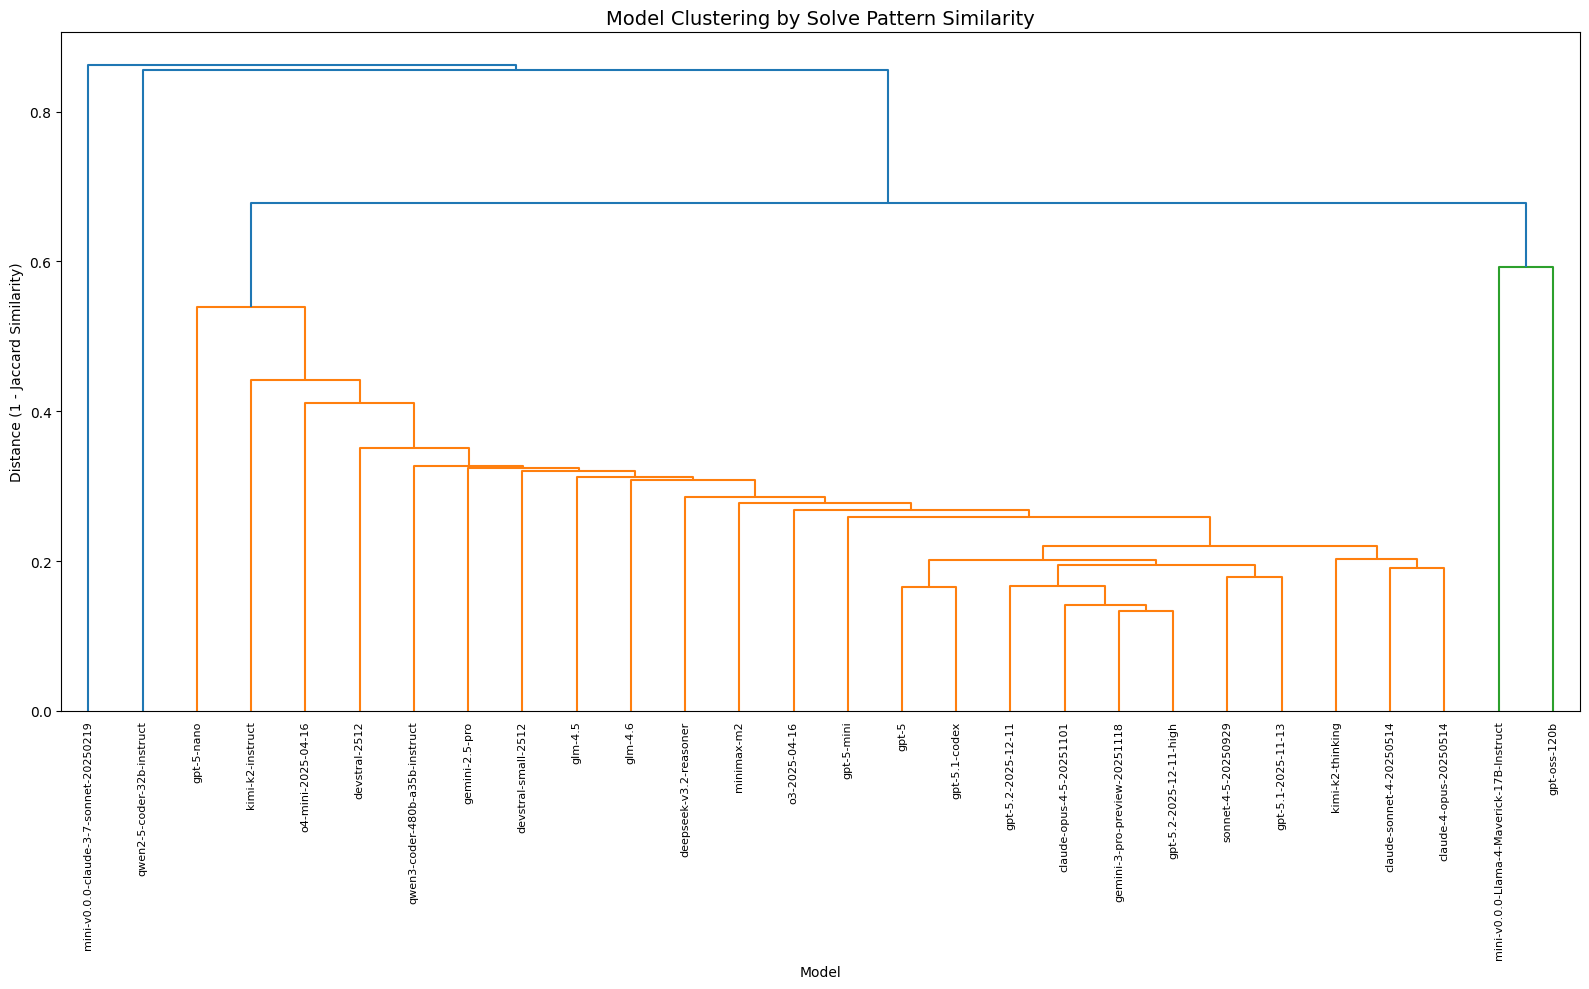

In [30]:
# 7.3 Model Similarity Dendrogram
distance_matrix = 1 - similarity_matrix.astype(float).values
condensed_dist = squareform(distance_matrix, checks=False)
Z = linkage(condensed_dist, method="average")

plt.figure(figsize=(16, 10))
dendrogram(
    Z,
    labels=model_names,
    leaf_rotation=90,
    leaf_font_size=8
)
plt.title("Model Clustering by Solve Pattern Similarity", fontsize=14)
plt.xlabel("Model")
plt.ylabel("Distance (1 - Jaccard Similarity)")
plt.tight_layout()
plt.show()

In [31]:
# 7.5 Timeline Performance Evolution
df_summary["month_label"] = df_summary["date"].apply(
    lambda x: f"{x[:4]}-{x[4:6]}"
)

best_per_month = df_summary.loc[df_summary.groupby("month_label")["resolved_count"].idxmax()]

fig = px.line(
    best_per_month.sort_values("date"),
    x="month_label",
    y="resolved_count",
    text="model_name",
    title="Best Model Performance Over Time (July - December 2025)",
    labels={"month_label": "Month", "resolved_count": "Resolved Instances"},
    markers=True
)

fig.update_traces(textposition="top center")
fig.update_layout(height=500)

fig.show()

In [32]:
# 7.4 Provider Comparison across Clusters (Radar Chart)
provider_cluster_performance = {}

for model in ALL_MODELS:
    info = parse_model_info(model)
    provider = info["provider"]
    model_name = info["model_name"]

    if provider not in provider_cluster_performance:
        provider_cluster_performance[provider] = {c: [] for c in range(n_clusters)}

    for c in range(n_clusters):
        error_rate = cluster_stats[model_name][c]["error_rate"]
        provider_cluster_performance[provider][c].append(error_rate)

provider_avg = {}
for provider, clusters in provider_cluster_performance.items():
    provider_avg[provider] = {c: np.mean(rates) for c, rates in clusters.items()}

categories = [f"Cluster {c}" for c in range(n_clusters)]

fig = go.Figure()

for provider in sorted(provider_avg.keys()):
    values = [1 - provider_avg[provider][c] for c in range(n_clusters)]
    values.append(values[0])  # Close the polygon

    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=categories + [categories[0]],
        name=provider,
        fill='toself',
        opacity=0.6
    ))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
    title="Provider Performance Across Clusters (Success Rate)",
    height=600
)

fig.show()

---
## Section 8: Summary Statistics

In [33]:
# Final summary statistics
print("="*80)
print("SWE-BENCH MODEL ANALYSIS - SUMMARY")
print("="*80)

print(f"\nDataset:")
print(f"  Verified instances: {len(instance_ids)}")
print(f"  Clusters: {n_clusters}")
print(f"  Models analyzed: {len(ALL_MODELS)}")
print(f"  Date range: July - December 2025")

print(f"\nOverall Performance:")
print(f"  Best model: {df_summary.iloc[0]['model_name']} ({df_summary.iloc[0]['resolved_count']} solved)")
print(f"  Worst model: {df_summary.iloc[-1]['model_name']} ({df_summary.iloc[-1]['resolved_count']} solved)")
print(f"  Average: {df_summary['resolved_count'].mean():.1f} instances")

print(f"\nInstance Difficulty:")
print(f"  Easy (all 34 solved): {len(universal_success)}")
print(f"  Impossible (none solved): {len(universal_failure)}")
print(f"  Unique solves (1 model only): {len(unique_solves)}")

print(f"\nBest Provider:")
best_provider = provider_stats.index[0]
print(f"  {best_provider} (avg: {provider_stats.loc[best_provider, 'Avg Resolved']:.1f} instances)")

print("\n" + "="*80)

SWE-BENCH MODEL ANALYSIS - SUMMARY

Dataset:
  Verified instances: 500
  Clusters: 7
  Models analyzed: 28
  Date range: July - December 2025

Overall Performance:
  Best model: claude-opus-4-5-20251101 (372 solved)
  Worst model: qwen2-5-coder-32b-instruct (45 solved)
  Average: 269.8 instances

Instance Difficulty:
  Easy (all 34 solved): 0
  Impossible (none solved): 63
  Unique solves (1 model only): 17

Best Provider:
  Google (avg: 319.5 instances)



---
## Section 9: Export Results

In [34]:
# Export results
export_path = CACHE_DIR / "instance_model_matrix.csv"
df_matrix.to_csv(export_path)
print(f"✅ Saved instance x model matrix to: {export_path}")

summary_path = CACHE_DIR / "model_summary.csv"
df_summary.to_csv(summary_path, index=False)
print(f"✅ Saved model summary to: {summary_path}")

# Export differential analysis
diff_analysis = {
    "universal_success": universal_success,
    "universal_failure": universal_failure,
    "unique_solves": {
        model: instances for model, instances in unique_solve_by_model.items()
    },
    "summary": {
        "total_instances": len(instance_ids),
        "total_models": len(ALL_MODELS),
        "best_model": df_summary.iloc[0]["model_name"],
        "best_resolved": int(df_summary.iloc[0]["resolved_count"]),
        "avg_resolved": float(df_summary["resolved_count"].mean())
    }
}

diff_path = CACHE_DIR / "differential_analysis.json"
with open(diff_path, "w") as f:
    json.dump(diff_analysis, f, indent=2)
print(f"✅ Saved differential analysis to: {diff_path}")

✅ Saved instance x model matrix to: /content/cache/instance_model_matrix.csv
✅ Saved model summary to: /content/cache/model_summary.csv
✅ Saved differential analysis to: /content/cache/differential_analysis.json


In [35]:
# Download results from Colab
from google.colab import files

print("📥 Downloading results...")

# Download key files
files.download(str(CACHE_DIR / "instance_model_matrix.csv"))
files.download(str(CACHE_DIR / "model_summary.csv"))
files.download(str(CACHE_DIR / "differential_analysis.json"))

print("\n✅ Download complete!")

📥 Downloading results...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Download complete!


In [36]:
# List all generated artifacts
print("\nGenerated Artifacts:")
print("=" * 60)

for f in sorted(CACHE_DIR.glob("*")):
    if f.name.endswith("_results.json"):
        continue  # Skip individual model caches
    size = f.stat().st_size / 1024
    if size > 1024:
        size_str = f"{size/1024:.1f} MB"
    else:
        size_str = f"{size:.1f} KB"
    print(f"  {f.name} ({size_str})")

print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE")
print("="*80)


Generated Artifacts:
  differential_analysis.json (2.9 KB)
  instance_model_matrix.csv (45.1 KB)
  model_summary.csv (2.8 KB)

✅ ANALYSIS COMPLETE
